In [2]:
from model import Transformer
import pandas as pd
from config import Config
from tokenizer import Tokenizer
import torch as t
import warnings
import json
from helpers import take_metrics, extract_answer_from_prediction

warnings.filterwarnings("ignore")

# Taking the Metrics of a Training Run

This notebook expects a path to a training run with regular checkpointing. For example: ``variable_digit_add_30``<br>
It will create a list of indices and run the ``take_metrics`` function on the subselection of models and store them in a ``metrics.json``.<br>
Finally, it will use the ``metrics.json`` to plot the digitwise test accuracies.

In [35]:
# Set the model path
dir_path = "saved_runs/variable_digit_add_50"

In [36]:
# read the config file
config_dict = json.load(open(f"{dir_path}/config.json"))
config = Config(**config_dict)
config

Config(lr=0.001, weight_decay=1.0, batch_size=256, p=100, d_model=128, fn_name='add', frac_train=0.5, num_epochs=3000, save_models=True, save_every=5, fixed_digit=False, n_warmup=10, stopping_thresh=-1, seed=0, num_layers=1, batch_style='full', d_vocab=14, num_digits=3, n_ctx=12, d_mlp=512, num_heads=4, act_type='ReLU', device=device(type='cpu'), use_ln=False, take_metrics_every_n_epochs=10)

# Selecting the subset of checkpointed models

In [4]:
def get_intermediate_model_paths(dir_path, beginning, end, num_models):
    '''
    if the granularity doesn't work function will simply fail when you try to load the models
    call this responsibly :)
    '''
    intervals = t.linspace(beginning, end, num_models+1).int()[1:-1].tolist()
    return intervals, [dir_path + f'/models/{num}.pth' for num in intervals] 

In [5]:
total_epochs = 3000
mid_points = [0, 10, 100, 300, 3000]
model_numbers = [2, 18, 10, 5]

assert len(mid_points) == len(model_numbers) + 1

model_paths = [dir_path + '/init.pth']
indices = [0]

for i in range(len(model_numbers)):
    new_indices, new_model_paths = get_intermediate_model_paths(dir_path, mid_points[i], mid_points[i+1], model_numbers[i])
    indices += new_indices
    model_paths += new_model_paths
    if mid_points[i+1] != total_epochs:
        indices.append(mid_points[i+1])
        model_paths.append(dir_path + f'/models/{mid_points[i+1]}.pth')

indices.append(total_epochs)
model_paths.append(dir_path + f'/final.pth')

print(indices)

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 840, 1380, 1920, 2460, 3000]


# Running the ``take_metrics`` function on the subset of models and storing the metrics in ``metrics.json``

Note: Models are on Mert's local repo only, he has to run this

In [7]:
all_metrics = []

for i in range(len(model_paths)):
    print(f"Taking metrics for model {indices[i]}:")
    metrics = take_metrics(model_paths[i], dir_path)
    print(metrics)


Taking metrics for model 0:
{'train_total_accuracy': 0.0, 'test_total_accuracy': 0.0}

Taking metrics for model 5:


FileNotFoundError: [Errno 2] No such file or directory: 'saved_runs/variable_digit_add_50/models/5.pth'

# Plotting the desired metrics from the ``metrics.json``

In [18]:
# Reading in metrics from json file
metrics_path = "saved_runs/variable_digit_add_30/metrics.json"
with open(metrics_path, "r") as f:
    all_metrics = json.load(f)

test_digit_keys = [key for key in list(all_metrics.values())[-1] if 'test_digit' in key]
#test_digit_keys = [key for key in all_metrics[-1].keys() if 'test_digit' in key]
test_digit_keys

['test_digit_0_accuracy', 'test_digit_1_accuracy', 'test_digit_2_accuracy']

In [26]:
N_digit = len(test_digit_keys)
test_digit_accuracy = dict()

for i in range(N_digit):
    k = f'test_digit_{i}_accuracy'
    test_digit_accuracy[i] = [metrics.get(k, 0.0) for metrics in all_metrics.values()]

[0.0, 0.10086330935251799, 0.1079136690647482, 0.09827338129496403, 0.10503597122302158, 0.09971223021582734, 0.10388489208633093, 0.0985611510791367, 0.11266187050359712, 0.1097841726618705, 0.7084892086330935, 0.1181294964028777, 0.29784172661870506, 0.902589928057554, 0.9293525179856115, 0.9458992805755395, 0.9515107913669065, 0.9585611510791366, 0.963021582733813, 0.962589928057554, 0.9687769784172662, 0.9709352517985611, 0.9658992805755395, 0.9749640287769784, 0.9733812949640288, 0.9766906474820144, 0.9766906474820144, 0.9749640287769784, 0.9781294964028777, 0.9735251798561151, 0.9776978417266187, 0.980431654676259, 0.9792805755395684, 0.9797122302158273, 0.977410071942446, 0.978273381294964, 0.9797122302158273, 0.9884892086330935, 0.9876258992805755, 0.9869064748201439, 0.9873381294964029]


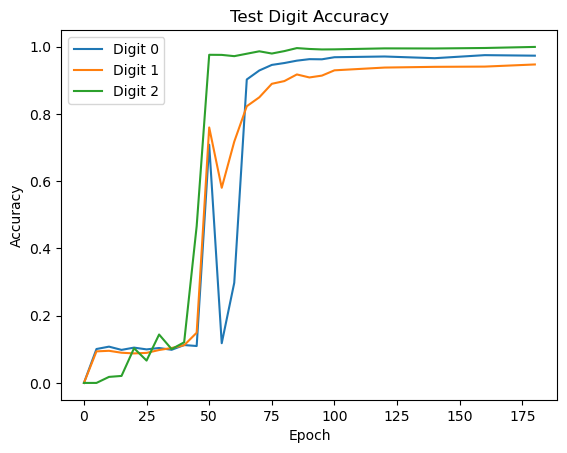

In [34]:
# plot each key in test digit accuracy with indices

import matplotlib.pyplot as plt

plot_first = 25

for i in range(N_digit):
    plt.plot(indices[:plot_first], test_digit_accuracy[i][:plot_first], label=f"Digit {i}")

plt.legend()
plt.title("Test Digit Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


# Plotting the train vs test accuracy to check for Grokking phenomenon

In [39]:
all_keys = list(all_metrics.values())[-1].keys()
print(f"All keys: {all_keys}\n")

keys = ["train_total_accuracy","test_total_accuracy"]
print(f"Selected keys: {keys}\n")

All keys: dict_keys(['train_total_accuracy', 'test_total_accuracy', 'train_digit_0_accuracy', 'test_digit_0_accuracy', 'train_digit_1_accuracy', 'test_digit_1_accuracy', 'test_digit_2_accuracy', 'train_digit_2_accuracy'])

Selected keys: ['train_total_accuracy', 'test_total_accuracy']



In [47]:
accuracy = dict()

for idx, case in enumerate(["train", "test"]):
    accuracy[case] = [metrics.get(keys[idx], 0.0) for metrics in all_metrics.values()]

print(f"Accuracy: {accuracy}\n")

Accuracy: {'train': [0.0, 0.0006557377049180328, 0.0006557377049180328, 0.0009836065573770492, 0.0006557377049180328, 0.0003278688524590164, 0.001639344262295082, 0.004918032786885246, 0.006885245901639345, 0.01377049180327869, 0.6049180327868853, 0.12229508196721312, 0.28491803278688527, 0.8065573770491803, 0.8632786885245901, 0.899344262295082, 0.9065573770491804, 0.9265573770491803, 0.9098360655737705, 0.9272131147540984, 0.9465573770491803, 0.9475409836065574, 0.9488524590163935, 0.9518032786885245, 0.9619672131147541, 0.959344262295082, 0.9613114754098361, 0.960327868852459, 0.9704918032786886, 0.9862295081967213, 0.9927868852459016, 0.9888524590163934, 0.9970491803278688, 0.9914754098360655, 0.9918032786885246, 0.9921311475409836, 0.9983606557377049, 1.0, 0.9983606557377049, 1.0, 1.0], 'test': [0.0, 0.0, 0.0, 0.00014388489208633093, 0.0005755395683453237, 0.00014388489208633093, 0.0005755395683453237, 0.002014388489208633, 0.0035971223021582736, 0.007194244604316547, 0.5428776978

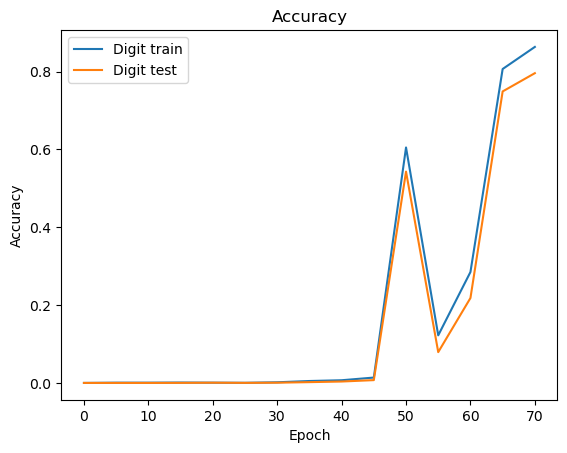

In [51]:
# plot each key in test digit accuracy with indices

import matplotlib.pyplot as plt

plot_first = 15

for i in ["train", "test"]:
    plt.plot(indices[:plot_first], accuracy[i][:plot_first], label=f"Digit {i}")

plt.legend()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# A function to convert the metrics.json to a pandas DataFrame

In [69]:
def metrics_json_to_df(model_dir):
    metrics_path = f"saved_runs/{model_dir}/metrics.json"

    # Reading in metrics from json file as a dictionary
    with open(metrics_path, "r") as f:
        all_metrics = json.load(f)

    # Convert to DataFrame
    df = pd.DataFrame.from_dict(all_metrics, orient='index')
    # Change the index of df from "1.pth" to 1
    df.index = df.index.str.replace('.pth', '').astype(int)
    return df

metrics_json_to_df("variable_digit_add_30").head()

,train_total_accuracy,test_total_accuracy,test_digit_0_accuracy,test_digit_1_accuracy,test_digit_2_accuracy,train_digit_0_accuracy,train_digit_1_accuracy,train_digit_2_accuracy
1,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
2,0.000656,0.000000,0.100863,0.093831,0.000000,0.098033,0.097107,0.000000
3,0.000656,0.000000,0.107914,0.095561,0.017924,0.101639,0.097107,0.019450
4,0.000984,0.000144,0.098273,0.089795,0.020815,0.098361,0.090788,0.021462
5,0.000656,0.000576,0.105036,0.087777,0.103209,0.099016,0.093449,0.090543


<Axes: >

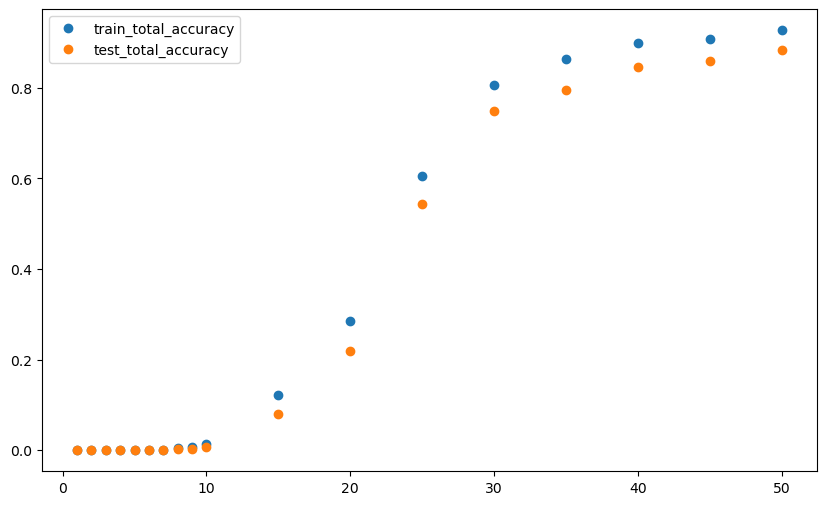

In [75]:
metrics_df = metrics_json_to_df("variable_digit_add_30")

# Plotting the metrics up to index 200
metrics_df.loc[:50, ["train_total_accuracy", "test_total_accuracy"]].plot(style='o', figsize=(10, 6))